In [1]:
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(rstatix))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(circlize))

In [2]:
options(repr.plot.width=12, repr.plot.height=12,warn = -1) #warn = 1

In [3]:
do.tissueDist <- function(cellInfo.tb = cellInfo.tb,
                          meta.cluster = cellInfo.tb$meta.cluster,
                          loc = cellInfo.tb$loc,
                          verbose=0){
    ##input data 
    cellInfo.tb = data.table(cellInfo.tb)
    cellInfo.tb$meta.cluster = as.character(meta.cluster)
    
    if(is.factor(loc)){
        cellInfo.tb$loc = loc
    }else{cellInfo.tb$loc = as.factor(loc)}
    
    loc.avai.vec <- levels(cellInfo.tb[["loc"]])
    count.dist <- unclass(cellInfo.tb[,table(meta.cluster,loc)])[,loc.avai.vec]
    freq.dist <- sweep(count.dist,1,rowSums(count.dist),"/")
    freq.dist.bin <- floor(freq.dist * 100 / 10)
    count.dist.melt.ext.tb <- test.dist.table(count.dist)
    p.dist.tb <- dcast(count.dist.melt.ext.tb,rid~cid,value.var='adj.p.value' # "p.value"
                      )
    OR.dist.tb <- dcast(count.dist.melt.ext.tb,rid~cid,value.var="OR")
    OR.dist.mtx <- as.matrix(OR.dist.tb[,-1])
    rownames(OR.dist.mtx) <- OR.dist.tb[[1]]
    
  
  if(verbose==1){
      return(list("count.dist.melt.ext.tb"=count.dist.melt.ext.tb,
                  "p.dist.tb"=p.dist.tb,
                  "OR.dist.tb"=OR.dist.tb,
                  "OR.dist.mtx"=OR.dist.mtx))
  }else{
      return(OR.dist.mtx)
  }
}

test.dist.table <- function(count.dist,min.rowSum=0){
    count.dist <- count.dist[rowSums(count.dist)>=min.rowSum,,drop=F]
    sum.col <- colSums(count.dist)
    sum.row <- rowSums(count.dist)
    count.dist.tb <- as.data.frame(count.dist)
    setDT(count.dist.tb,keep.rownames=T)
    count.dist.melt.tb <- melt(count.dist.tb,id.vars="rn")
    colnames(count.dist.melt.tb) <- c("rid","cid","count")
    count.dist.melt.ext.tb <- as.data.table(ldply(seq_len(nrow(count.dist.melt.tb)), function(i){
        this.row <- count.dist.melt.tb$rid[i]
        this.col <- count.dist.melt.tb$cid[i]
        this.c <- count.dist.melt.tb$count[i]
        other.col.c <- sum.col[this.col]-this.c
        this.m <- matrix(c(this.c,
                           sum.row[this.row]-this.c,
                           other.col.c,
                           sum(sum.col)-sum.row[this.row]-other.col.c),
                         ncol=2)
        res.test <- fisher.test(this.m)
        data.frame(rid=this.row,
                   cid=this.col,
                   p.value=res.test$p.value,
                   OR=res.test$estimate)
    }))
    count.dist.melt.ext.tb <- merge(count.dist.melt.tb,count.dist.melt.ext.tb,by=c("rid","cid"))
    count.dist.melt.ext.tb[,adj.p.value:=p.adjust(p.value,"BH")]
    return(count.dist.melt.ext.tb)
}

In [4]:
ggHeat <- function(m, rescaling = 'none', clustering = 'none',
                   labCol = T, labRow = T, border = F,
                   heatscale = c(low = 'skyblue', mid = 'white', high = 'tomato'),
                   legend.title = NULL, x.lab.size = 10,
                   y.lab.size = 10,
                   dot.highlight.cutoff = Inf) {
  ## you can either scale by row or column not both!
  ## if you wish to scale by both or use a differen scale method then simply supply a scale
  ## function instead NB scale is a base funct

  if(is.function(rescaling)) {
    m = rescaling(m)
  } else
  {
    if(rescaling == 'column')
      m = scale(m, center = T)
    if(rescaling == 'row')
      m = t(scale(t(m), center = T))
  }

  ## I have supplied the default cluster and euclidean distance- and chose to cluster after scaling
  ## if you want a different distance/cluster method-- or to cluster and then scale
  ## then you can supply a custom function

  if(is.function(clustering)) {
    m = clustering(m)
  } else {
    if(clustering == 'row')
      m = m[hclust(dist(m))$order, ]
    if(clustering == 'column')
      m = m[ ,hclust(dist(t(m)))$order]
    if(clustering=='both')
      m = m[hclust(dist(m))$order, hclust(dist(t(m)))$order]
  }
  col.labels <- colnames(m)
  row.labels <- rownames(m)

  colnames(m) <- paste0(col.labels, 1:ncol(m))
  rownames(m) <- paste0(row.labels, 1:nrow(m))

  ## this is just reshaping into a ggplot format matrix and making a ggplot layer
  melt.m = reshape2::melt(m)
  colnames(melt.m) <- c("Var1", "Var2", "value")
  g2 <- ggplot(data = melt.m) + geom_tile(aes(x = factor(Var2, levels = colnames(m)),
                                              y = factor(Var1, levels = rownames(m)),
                                              fill = value))
  g2 <- g2 + scale_x_discrete(labels = col.labels) + scale_y_discrete(labels = row.labels)

  ## get rid of grey panel background and gridlines
  g2 = g2 + theme(panel.grid.minor = element_line(colour = NA), panel.grid.major = element_line(colour=NA),
                  panel.background = element_rect(fill = NA, colour = NA), axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = x.lab.size),
                  axis.ticks = element_blank(), axis.text.y = element_text(size = y.lab.size, hjust = 1, vjust = 0.5),
                  axis.title = element_blank())

  ## finally add the fill colour ramp of your choice (default is blue to red)-- and return
  g2 <- g2 + scale_fill_gradient2(low = heatscale[1], mid = heatscale[2], high = heatscale[3],midpoint = 1,
                                  guide = guide_colorbar(title = legend.title))

  ## Add dots to highlight certain cells
  dot.melt.m <- subset(melt.m, value > dot.highlight.cutoff)
  if (nrow(dot.melt.m) > 0) {
    g2 <- g2 + geom_point(aes(x = Var2, y = Var1), data = dot.melt.m)
  }

  ## Remove axis labels
  if(labCol == F) g2 = g2 + theme(axis.text.x = element_blank())
  if(labRow == F) g2 = g2 + theme(axis.text.y = element_blank())

  return(g2)
}

In [5]:
`%ni%` <- Negate(`%in%`) 

# Load data

In [6]:
meta.tb <- read.csv('data/NSCLC_metadata.csv')
setDT(meta.tb)

In [7]:
head(meta.tb)

cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,Max.G,⋯,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors,leiden,cell_comm,celltype
<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>
c_3_1_3,1,2666,1.40,70,50,1770,3611,2213,14635,⋯,1.602060,0.008619492,False,Lung5,plasmablast,plasmablast-enriched stroma,0.11,1,CC2,plasmablast
c_3_1_5,1,2569,1.13,61,54,3913,9346,1005,5156,⋯,1.602060,0.008619492,False,Lung5,macrophage,plasmablast-enriched stroma,0.00,1,CC2,macrophage
c_3_1_6,1,2678,1.20,67,56,4786,11066,666,5069,⋯,2.008600,0.021979705,False,Lung5,B-cell,stroma,0.00,1,CC2,B-cell
c_3_1_7,1,3301,1.39,75,54,1747,7005,646,3558,⋯,1.690196,0.010558878,False,Lung5,neutrophil,stroma,0.00,1,CC2,neutrophil
c_3_1_8,1,2087,1.02,52,51,3134,6292,581,1288,⋯,1.778151,0.012929238,False,Lung5,endothelial,lymphoid structure,0.01,0,CC1,endothelial
c_3_1_11,1,3030,1.82,89,49,3535,6186,607,2447,⋯,2.021189,0.022626167,False,Lung5,plasmablast,lymphoid structure,0.01,2,CC3,plasmablast


In [8]:
cellInfo.tb=meta.tb
OR.list <- do.tissueDist(cellInfo.tb=cellInfo.tb,
                           meta.cluster = cellInfo.tb$celltype,
                           loc = cellInfo.tb$cell_comm,
                           verbose=1)

In [9]:
df_OR <- OR.list$OR.dist.mtx

In [10]:
df_P <- OR.list$p.dist.tb

In [11]:
Cell_commColors=c('CC1'='#1f77b4','CC2'='#ff7f0e','CC3'='#279e68','CC4'='#d62728','CC5'='#aa40fc',
                  'CC6'='#8c564b')# 'CC7'='#e377c2','CC8'='#b5bd61','CC9'='#17becf'

In [12]:
df = df_OR
df = df[,c('CC1','CC2','CC3','CC4','CC5','CC6')]

# 构建列注释信息
annotation_col = data.frame(
    Cell_comm = c('CC1','CC2','CC3','CC4','CC5','CC6')
)
rownames(annotation_col) = c('CC1','CC2','CC3','CC4','CC5','CC6')

ann_colors = list(
    Cell_comm = c('CC1'='#1f77b4','CC2'='#ff7f0e','CC3'='#279e68','CC4'='#d62728','CC5'='#aa40fc','CC6'='#8c564b')
)


top_anno = HeatmapAnnotation(Cell_comm = c('CC1','CC2','CC3','CC4','CC5','CC6'), 
                             col = list(Cell_comm=Cell_commColors))

tissue_info<-c('CC1','CC2','CC3','CC4','CC5','CC6')
names(tissue_info) <- c('CC1','CC2','CC3','CC4','CC5','CC6')

df[df>5] <- 5
head(df)

,CC1,CC2,CC3,CC4,CC5,CC6
B-cell,0.1819007,1.0146062,5.0000000,0.5598031,0.006679086,0.06094054
NK,2.7261037,0.8614833,0.5440088,1.4957094,0.095715982,0.59165797
T CD4 memory,0.2859369,1.9897860,2.0310935,1.9093906,0.020287422,0.36288859
T CD4 naive,0.3909236,1.2840420,5.0000000,0.9138101,0.011167536,0.11100384
T CD8 memory,0.6696231,1.5967984,1.8071642,1.4439102,0.211860642,0.39179714
T CD8 naive,0.3459832,1.2610902,2.8260108,2.2563359,0.025378070,0.22936461


In [13]:
#热图格子大小设置；
cellwidth = 0.6
cellheight = 0.6
cn = dim(df)[2]
rn = dim(df)[1]
w=cellwidth*cn
h=cellheight*rn

In [14]:
col_fun1 = colorRamp2(c(0, 1, 3, 5), c("#0f86a9", "white", "#FC8452","#ff5b17")) 

In [15]:
df_p <- as.matrix(df_P[,-1])
rownames(df_p) <- df_P$rid

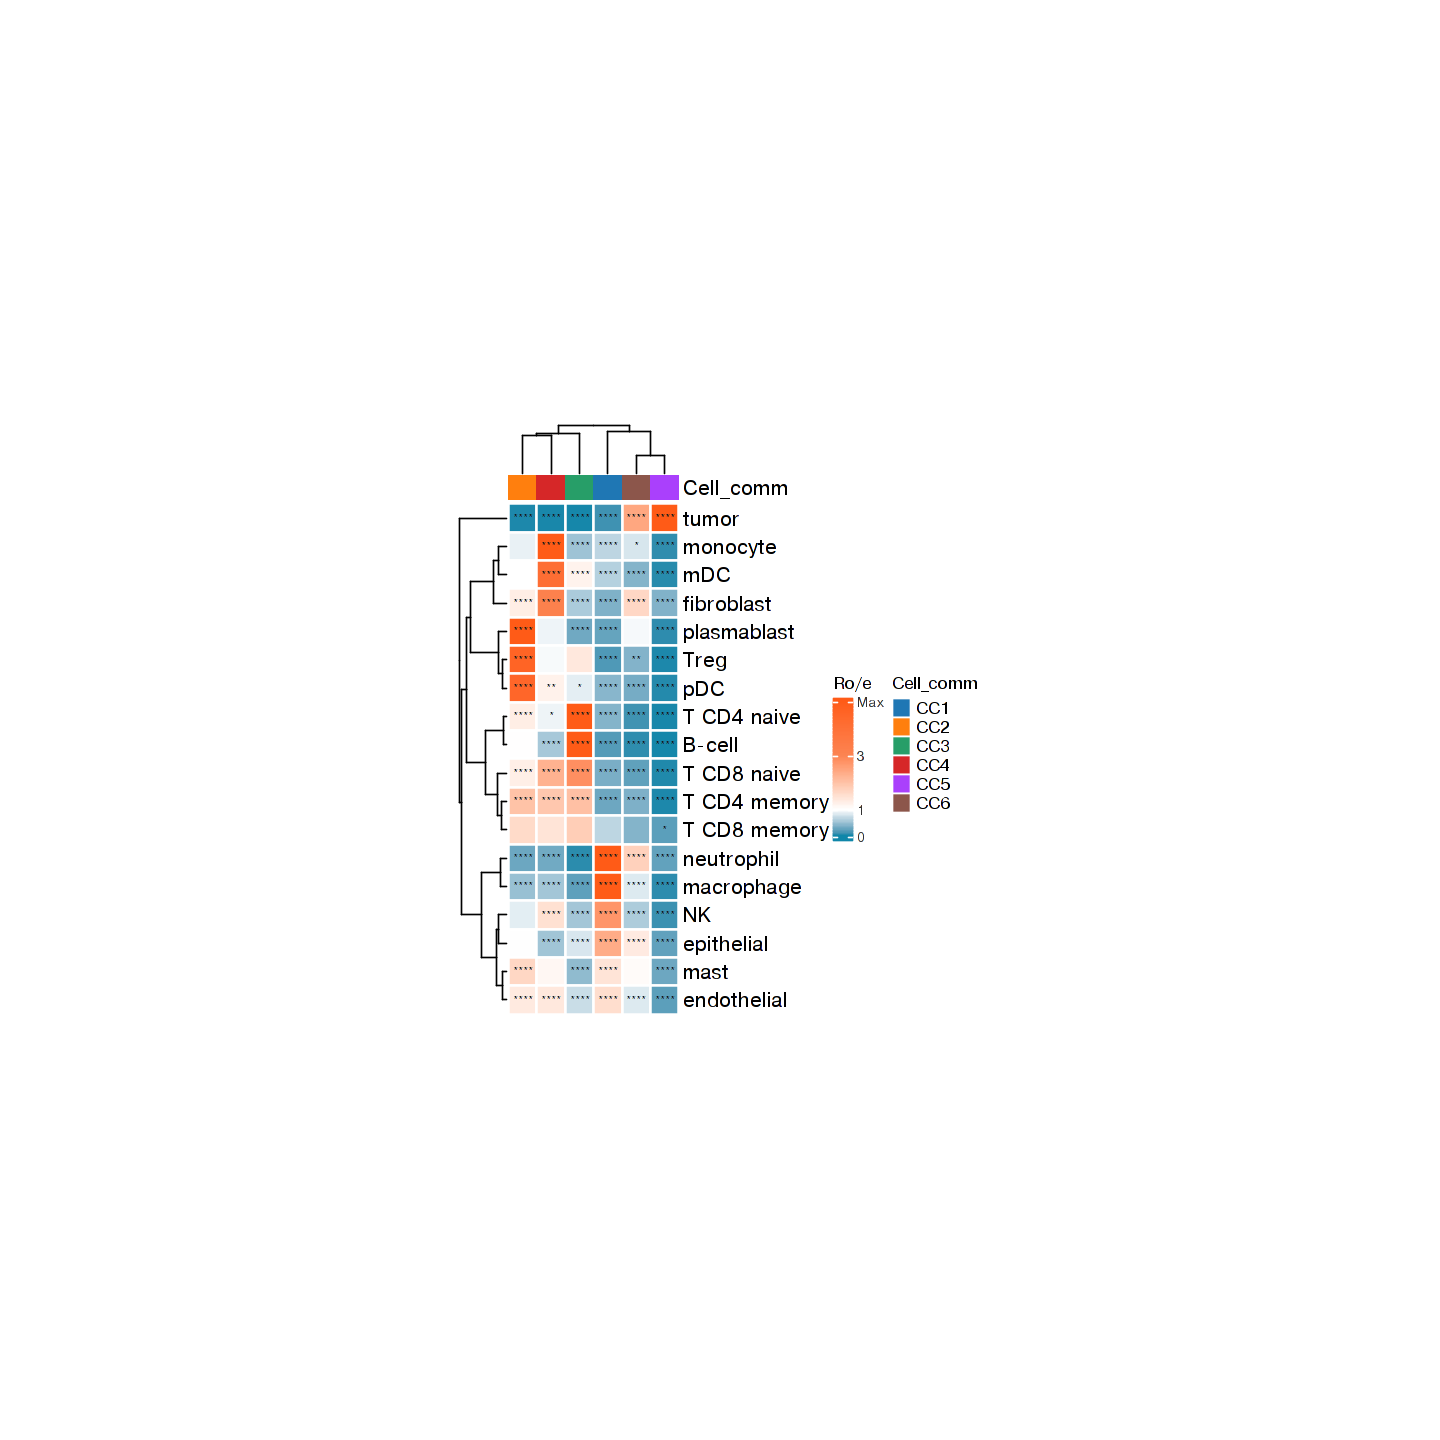

In [16]:
Heatmap(df,name ="r", col = col_fun1,
        show_column_names = FALSE,
        show_row_names = TRUE,
        top_annotation = top_anno,
        #格子大小设置；
        width = unit(w, "cm"),
        height = unit(h, "cm"),
        rect_gp = gpar(col = "white", lwd = 1.5),
        #聚类树样式设置；
        cluster_rows = TRUE,
        cluster_columns = TRUE,
        #行列标签文字样式设置；
        row_title = NULL,column_title = NULL,
        column_names_gp = gpar(fontsize = 12),
        row_names_gp = gpar(fontsize = 12),
        #图例样式设置；
        heatmap_legend_param = list(legend_height = unit(3, "cm"),
                                    grid_width = unit(0.4, "cm"),
                                    labels_gp = gpar(col = "gray20",fontsize = 8),
                                    title = "Ro/e", at = c(0, 1, 3, 5),labels = c("0", "1",'3',"Max")),
        #使用加减号表示正负相关；
        cell_fun = function(j, i, x, y, width, height, fill) {
          if(df_p[i, j] > 0.01){
            grid.text("", x, y,
                   gp = gpar(fontsize = 6,
                             fontface = "plain",
                             col="gray10"))
          }else if(df_p[i, j] > 0.001 & df_p[i, j] <= 0.01){
            grid.text("*", x, y, vjust = 0.4,
                   gp = gpar(fontsize = 6,
                             fontface = "plain",
                             col="gray10"))
          }else if(df_p[i, j] > 0.0001 & df_p[i, j] <= 0.001){
            grid.text("**", x, y, vjust = 0.4,
                   gp = gpar(fontsize = 6,
                             fontface = "plain",
                             col="gray10"))
          }else if(df_p[i, j] > 0.00001 & df_p[i, j] <= 0.0001){
            grid.text("***", x, y, vjust = 0.4,
                   gp = gpar(fontsize = 6,
                             fontface = "plain",
                             col="gray10"))
          }else if(df_p[i, j] <= 0.00001){
            grid.text("****", x, y, vjust = 0.4,
                   gp = gpar(fontsize = 6,
                             fontface = "plain",
                             col="gray10"))
          }
        }
)